In [613]:
import numpy as np
from IPython import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
from torchtext.legacy import data
from torchtext.legacy import datasets
import torchtext.vocab
from torchtext.vocab import Vocab
import gensim
from scipy.spatial.distance import cosine
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

sns.set(style='whitegrid', font_scale=3.0)
%matplotlib inline

In [6]:
# Установка random seed для воспроизводимости эксперимента
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Загрузим данные. Разобъём на `train`, `valid`, `test`

In [129]:
# Загрузка данных и разбивка на токены
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

In [130]:
# Разделение данных на train, test
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [131]:
# Разделение данных на train, valid
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [132]:
def cut_words(ddata, max_length=20):
    '''Обрезать тексты по первым max_length словам'''
    
    for i in range(len(ddata.examples)):
        ddata.examples[i].text = ddata.examples[i].text[:max_length]

In [133]:
# Укорачивание текстов 
cut_words(train_data)
cut_words(valid_data)
cut_words(test_data)

In [144]:
# Построение словаря по данным
# Используются предобученные эмбединги для построения векторов
MAX_VOCAB_SIZE = 10_000

TEXT.build_vocab(train_data,
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [325]:
# Размер эмбединга
EMB_DIM = TEXT.vocab.vectors[0].shape[0]

In [570]:
def get_idx_embedding(idx):
    '''Получить эмбединг по индексу'''
    
    return TEXT.vocab.vectors[idx]


def get_word_embedding(word):
    '''Получить эмбединг по слову'''
    
    idx = TEXT.vocab.stoi[word]
    return get_idx_embedding(idx)


def get_text_embeddings(text):
    '''Получить эмбединги по тексту из индексов'''

    return TEXT.vocab.vectors[text]


def get_texts_embeddings(texts):
    '''Получить эмбединги по текстам из индексов'''

    return torch.stack([get_text_embeddings(text) for text in texts])


def get_word_texts_embeddings(texts):
    '''Получить эмбединги по текстам из слов'''
    
    texts = TEXT.process([TEXT.tokenize(text) for text in texts])
    return get_texts_embeddings(texts)

In [422]:
# Поиск ближайшего вектора по косинусному расстоянию
neigh = NearestNeighbors(n_neighbors=3,
                         metric='cosine',
                         algorithm='brute',
                         n_jobs=-1)
neigh.fit(TEXT.vocab.vectors)


def get_synonim(word, tol=0.5):
    '''Получить синоним слова word с косинусным расстоянием
    между эмбедингами не более tol'''
    
    wv = get_word_embedding(word)
    cosine_dist, idxs = neigh.kneighbors(wv.reshape(1, -1))
    cosine_dist = cosine_dist[0]
    idxs = idxs[0]
    for i in range(len(idxs)):
        if cosine_dist[i] > tol:
            continue
        sim_word = TEXT.vocab.itos[idxs[i]]
        if sim_word != word:
            return sim_word
    return word

In [148]:
# Генерация пакетов (батчей) данных для обучения, валидации и тесто
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

Опишем модель $-$ базовая `RNN`

In [437]:
class RNN(nn.Module):
    '''RNN модель из rnn слоя и fully-connected слоя'''
    
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, embedded):
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [438]:
# Инициализация модели с заданными параметрами
EMB_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1

model = RNN(EMB_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM)

In [439]:
# Инициализация оптимизатора и критерия(функции потерь)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

In [228]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [282]:
def train(model, iterator, optimizer, criterion):
    '''Одна эпоха обучения модели'''
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()

        embedded = get_texts_embeddings(batch.text)

        predictions = model(embedded).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [283]:
def evaluate(model, iterator, criterion):
    '''Валидация модели'''
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            embedded = get_texts_embeddings(batch.text)
            
            predictions = model(embedded).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [284]:
def epoch_time(start_time, end_time):
    '''Время вычисления эпохи'''
    
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [235]:
# Обучение модели
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'imdb20.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.667 | Train Acc: 60.11%
	 Val. Loss: 0.670 |  Val. Acc: 59.40%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.665 | Train Acc: 59.66%
	 Val. Loss: 0.687 |  Val. Acc: 55.20%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.657 | Train Acc: 61.62%
	 Val. Loss: 0.667 |  Val. Acc: 60.68%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.646 | Train Acc: 63.71%
	 Val. Loss: 0.670 |  Val. Acc: 59.71%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.643 | Train Acc: 63.78%
	 Val. Loss: 0.663 |  Val. Acc: 60.60%


In [440]:
# Загрузка модели
model.load_state_dict(torch.load('imdb20.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.662 | Test Acc: 60.96%


In [617]:
def generate_sample(data, size=1000, random_state=42):
    '''Генерация выборки из заданных данных'''
    
    np.random.seed(random_state)
    sample_idx = np.random.randint(0, len(data), sample_size)
    sample_texts = [data[idx].text for idx in sample_idx]
    return sample_texts


def generate_similar(text, p=0.1):
    '''Генерация текста из синонимов с вероятностью замены p'''
    
    sim_text = []
    for i in range(len(text)):
        word = text[i]
        if np.random.random() <= p:
            word = get_synonim(word)
        sim_text.append(word)
    return sim_text


def make_pred_chart(true_val, pred_val, label, save_path):
    '''Отобразить график предсказаний'''
    
    args = np.argsort(true_val)[::-1]
    plt.figure(figsize=(10, 8))
    plt.plot(pred_val[args], lw=2, label=label)
    plt.plot(true_val[args], lw=3, label='Истинные предсказания')
    plt.xlabel('Индекс объекта')
    plt.legend(fontsize=24)
    plt.savefig(save_path, format='svg')
    plt.show()
    

def make_cosine_chart(true_val, pred_val, label, save_path):
    '''Отобразить график косинусного расстояния'''
    
    dists = [cosine([true_val[i], 1 - true_val[i]], 
                    [pred_val[i], 1 - pred_val[i]])
             for i in range(len(true_val))]
    dists = np.sort(dists)
    
    plt.figure(figsize=(10, 8))
    plt.plot(dists, lw=3, label=label)
    plt.xlabel('Индекс объекта')
    plt.legend(fontsize=24)
    plt.savefig(save_path, format='svg')
    plt.show()

    
def predict_proba_lime(texts):
    '''Предсказания вероятностьй для метода LIME'''
    
    with torch.no_grad():
        embedded = get_word_texts_embeddings(texts)
        
        model.eval()
        pred = torch.sigmoid(model(embedded)).squeeze()

    return torch.stack([1 - pred, pred]).T


def print_metrics(true_val, pred_val):
    '''Напечатать метрики качества'''
    
    rmse = np.sqrt(np.mean((true_val - pred_val) ** 2))
    mae = np.mean(np.abs(true_val - pred_val))
    mape = np.mean(np.abs(true_val - pred_val) / true_val)
    
    print(f'RMSE: {rmse:.5f}')
    print(f'MAE: {mae:.5f}')
    print(f'MAPE: {mape:.5f}')


def make_experiment_openbox(texts, sim_texts):
    '''Запустить эксперимент для метода OpenBox'''
    
    indexed = TEXT.process(texts)
    sim_indexed = TEXT.process(sim_texts)
    
    embedded = get_texts_embeddings(indexed)
    embedded.requires_grad = True
    sim_embedded = get_texts_embeddings(sim_indexed)
    
    model.eval()
    pred = torch.sigmoid(model(embedded)).squeeze()
    sim_pred = torch.sigmoid(model(sim_embedded)).squeeze()
    
    pred.sum().backward()
    grad = embedded.grad
    
    delta_x = sim_embedded - embedded
    delta_pred = torch.sum(delta_x * grad, axis=[0, 2])
    openbox_pred = pred + delta_pred
    
    pred_np = pred.detach().cpu().numpy()
    sim_pred_np = sim_pred.detach().cpu().numpy()
    openbox_pred_np = openbox_pred.detach().cpu().numpy()
    
    make_pred_chart(sim_pred_np,
                    openbox_pred_np,
                    'OpenBox',
                    '../figures/openbox_proba_est.svg')
    
    make_cosine_chart(sim_pred_np,
                      openbox_pred_np,
                      'OpenBox',
                      '../figures/openbox_cosine.svg')
    
    print_metrics(sim_pred_np, openbox_pred_np)


def make_experiment_lime(texts):
    '''Запустить эксперимент для метода LIME'''
    
    with torch.no_grad():
        indexed = TEXT.process(texts)
        embedded = get_texts_embeddings(indexed)

        model.eval()
        pred = torch.sigmoid(model(embedded)).squeeze()
    
    lime_pred = []
    for text in tqdm(texts):
        exp = explainer.explain_instance(" ".join(text),
                                         predict_proba_lime, num_features=6)
        lime_pred.append(exp.predict_proba[1].item())
    
    pred_np = pred.detach().cpu().numpy()
    lime_pred_np = np.array(lime_pred)
    
    make_pred_chart(pred_np,
                    lime_pred_np,
                    'LIME',
                    '../figures/lime_proba_est.svg')
    
    make_cosine_chart(pred_np,
                      lime_pred_np,
                      'LIME',
                      '../figures/lime_cosine.svg')
    
    print_metrics(pred_np, lime_pred_np)

In [603]:
sample_texts = generate_sample(test_data)
sim_texts = [generate_similar(text, p=0.2) for text in tqdm(sample_texts)]

  0%|          | 0/1000 [00:00<?, ?it/s]

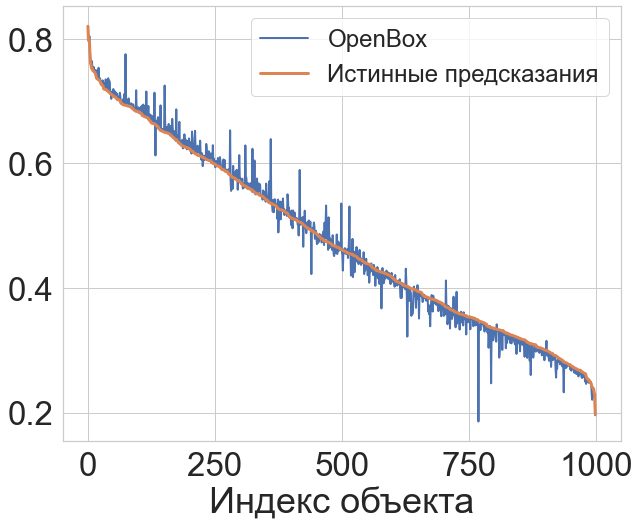

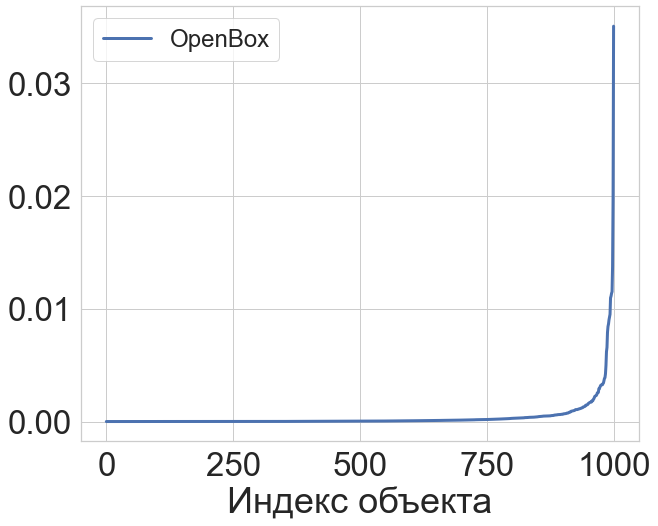

RMSE: 0.01541
MAE: 0.00849
MAPE: 0.01923


In [618]:
make_experiment_openbox(sample_texts, sim_texts)

  0%|          | 0/1000 [00:00<?, ?it/s]

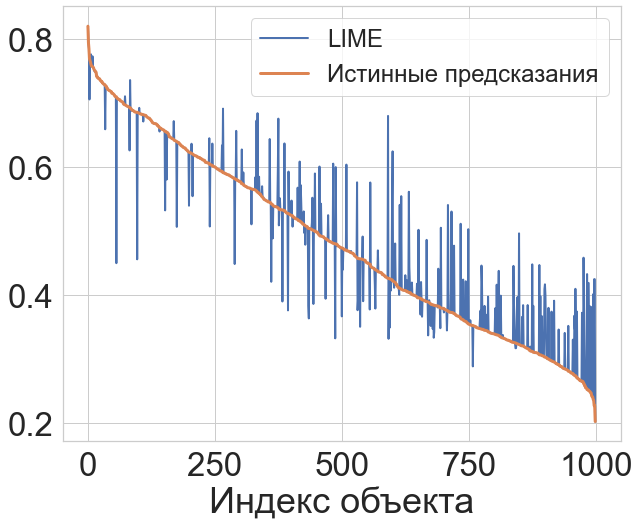

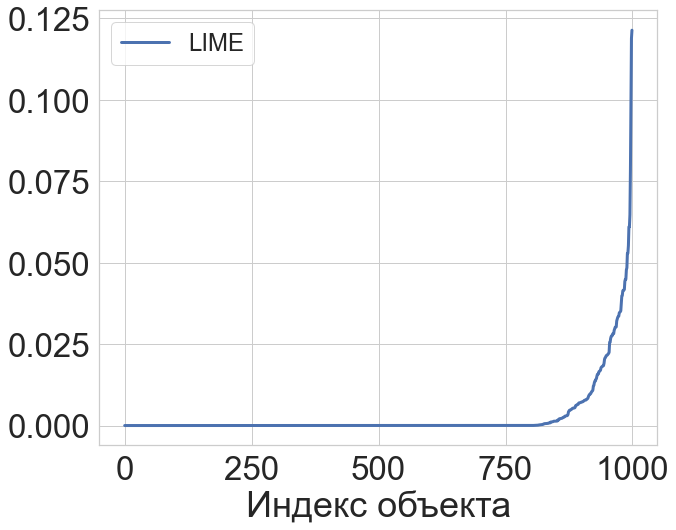

RMSE: 0.04085
MAE: 0.01479
MAPE: 0.03923


In [619]:
make_experiment_lime(sample_texts)